# Random forests

### Classification into percentiles

In [1]:
import matplotlib.pyplot as plt

plt.style.use("customstyle.mplstyle")

In [2]:
from pathlib import Path

DATA_FOLDER = Path("../data")

In [3]:
import pandas as pd

collisions = pd.read_pickle(DATA_FOLDER / "final_dataset.pkl")
collisions_df = collisions.drop(columns=["physicalid", "geometry"])

In [219]:
collisions_df["is_top_1"] = collisions_df["percentile"] == "top_1"
collisions_df["is_top_5"] = collisions_df["percentile"] >= "top_5"
collisions_df["is_top_10"] = collisions_df["percentile"] >= "top_10"
collisions_df["is_top_50"] = collisions_df["percentile"] >= "top_50"
collisions_df.dropna(subset="traffic_volume", inplace=True)

In [220]:
from sklearn.model_selection import train_test_split

collisions_train, collisions_test = train_test_split(
    collisions_df, test_size=0.2, random_state=42
)

In [221]:
import numpy as np
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy="mean", missing_values=0)
collisions_train[["st_width"]] = mean_imputer.fit_transform(
    collisions_train[["st_width"]]
)

collisions_train["has_bike_lane"] = ~(collisions_train["bike_lane"] == "nan")
collisions_train["has_parking"] = collisions_train["n_parking_meters"] > 0
collisions_train["speed_limit"] = collisions_train["speed_limit"].fillna(value=25)

is_av_mask = (
    (collisions_train["post_type"].isin(["AVE", "BLVD"]))
    | (collisions_train["pre_type"] == "AVE")
    | (collisions_train["st_name"].isin(["BROADWAY", "BOWERY"]))
)
is_st_mask = collisions_train["post_type"] == "ST"
is_rd_mask = collisions_train["post_type"].isin(["RD", "ROAD"])

collisions_train["is_av"] = is_av_mask
collisions_train["is_st"] = is_st_mask
collisions_train["is_rd"] = is_rd_mask

collisions_train["log_leng"] = np.log(collisions_train["shape_leng"])
collisions_train["log_width"] = np.log(collisions_train["st_width"])
collisions_train["inv_trees"] = 1.0 / (1 + collisions_train["n_trees"])
collisions_train["trees_per_leng"] = (
    collisions_train["n_trees"] / collisions_train["shape_leng"]
)

In [7]:
features = [
    "log_width",
    "log_leng",
    "has_humps",
    "has_parking",
    "has_bike_lane",
    "is_av",
    "is_st",
    "is_rd",
    "trees_per_leng",
    "traffic_volume",
]

X_train = collisions_train[features]
y_train_1 = collisions_train["is_top_1"].copy()
y_train_5 = collisions_train["is_top_5"].copy()
y_train_10 = collisions_train["is_top_10"].copy()
y_train_50 = collisions_train["is_top_50"].copy()

In [8]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(
    X_train, y_train_1, stratify=y_train_1, test_size=0.1, random_state=42
)
X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(
    X_train, y_train_5, stratify=y_train_5, test_size=0.1, random_state=42
)
X_train_10, X_val_10, y_train_10, y_val_10 = train_test_split(
    X_train, y_train_10, stratify=y_train_10, test_size=0.1, random_state=42
)
X_train_50, X_val_50, y_train_50, y_val_50 = train_test_split(
    X_train, y_train_50, stratify=y_train_50, test_size=0.1, random_state=42
)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns = X_train.columns
X_train_norm_1 = scaler.fit_transform(X_train_1)
X_train_norm_5 = scaler.fit_transform(X_train_5)
X_train_norm_10 = scaler.fit_transform(X_train_10)
X_train_norm_50 = scaler.fit_transform(X_train_50)

X_val_norm_1 = scaler.fit_transform(X_val_1)
X_val_norm_5 = scaler.fit_transform(X_val_5)
X_val_norm_10 = scaler.fit_transform(X_val_10)
X_val_norm_50 = scaler.fit_transform(X_val_50)


X_train_norm_1 = pd.DataFrame(X_train_norm_1, columns=columns)
X_train_norm_5 = pd.DataFrame(X_train_norm_5, columns=columns)
X_train_norm_10 = pd.DataFrame(X_train_norm_10, columns=columns)
X_train_norm_50 = pd.DataFrame(X_train_norm_50, columns=columns)


X_val_norm_1 = pd.DataFrame(X_val_norm_1, columns=columns)
X_val_norm_5 = pd.DataFrame(X_val_norm_5, columns=columns)
X_val_norm_10 = pd.DataFrame(X_val_norm_10, columns=columns)
X_val_norm_50 = pd.DataFrame(X_val_norm_50, columns=columns)

In [10]:
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)

X_over_1, y_over_1 = over_sampler.fit_resample(X_train_norm_1, y_train_1)
X_over_5, y_over_5 = over_sampler.fit_resample(X_train_norm_5, y_train_5)
X_over_10, y_over_10 = over_sampler.fit_resample(X_train_norm_10, y_train_10)
X_over_50, y_over_50 = over_sampler.fit_resample(X_train_norm_50, y_train_50)

In [11]:
from sklearn.ensemble import RandomForestClassifier

base_random_forest = RandomForestClassifier()

In [12]:
from sklearn.metrics import precision_recall_curve


def plot_precision_recall_curve(model, X_train, y_train, X_val, y_val, percentile):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba[:, 1])
    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.legend()
    plt.title(f"Top {percentile}% Precision and Recall")
    plt.xlabel("Threshold")

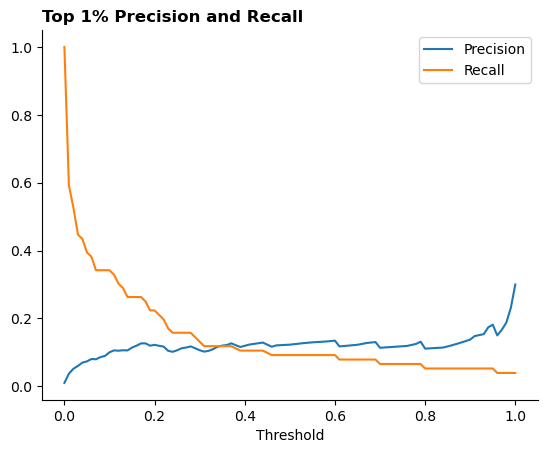

In [13]:
plot_precision_recall_curve(
    base_random_forest, X_over_1, y_over_1, X_val_norm_1, y_val_1, 1
)

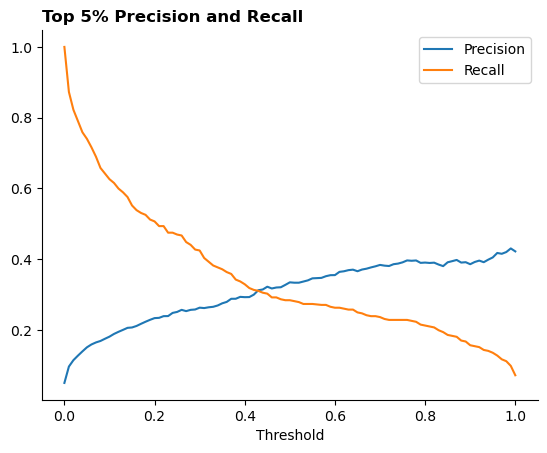

In [14]:
plot_precision_recall_curve(
    base_random_forest, X_over_5, y_over_5, X_val_norm_5, y_val_5, 5
)

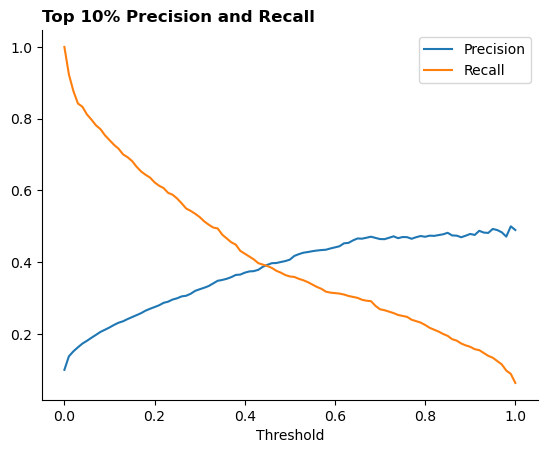

In [15]:
plot_precision_recall_curve(
    base_random_forest, X_over_10, y_over_10, X_val_norm_10, y_val_10, 10
)

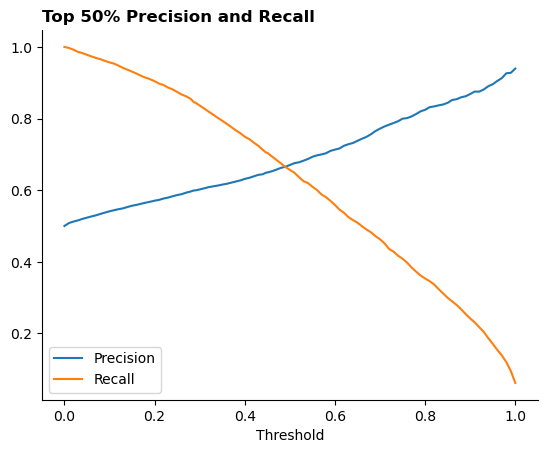

In [16]:
plot_precision_recall_curve(
    base_random_forest, X_over_50, y_over_50, X_val_norm_50, y_val_50, 50
)

### Binary classification between top and bottom half

In [17]:
from sklearn.model_selection import train_test_split

collisions_train, collisions_test = train_test_split(
    collisions_df, test_size=0.2, random_state=42
)

In [18]:
import numpy as np
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy="mean", missing_values=0)
collisions_train[["st_width"]] = mean_imputer.fit_transform(
    collisions_train[["st_width"]]
)

collisions_train["has_bike_lane"] = ~(collisions_train["bike_lane"] == "nan")
collisions_train["has_parking"] = collisions_train["n_parking_meters"] > 0
collisions_train["speed_limit"] = collisions_train["speed_limit"].fillna(value=25)

is_av_mask = (
    (collisions_train["post_type"].isin(["AVE", "BLVD"]))
    | (collisions_train["pre_type"] == "AVE")
    | (collisions_train["st_name"].isin(["BROADWAY", "BOWERY"]))
)
is_st_mask = collisions_train["post_type"] == "ST"
is_rd_mask = collisions_train["post_type"].isin(["RD", "ROAD"])

collisions_train["is_av"] = is_av_mask
collisions_train["is_st"] = is_st_mask
collisions_train["is_rd"] = is_rd_mask

collisions_train["log_leng"] = np.log(collisions_train["shape_leng"])
collisions_train["log_width"] = np.log(collisions_train["st_width"])
collisions_train["inv_trees"] = 1.0 / (1 + collisions_train["n_trees"])
collisions_train["trees_per_leng"] = (
    collisions_train["n_trees"] / collisions_train["shape_leng"]
)

In [19]:
features = [
    "log_width",
    "log_leng",
    "has_humps",
    "has_parking",
    "has_bike_lane",
    "is_av",
    "is_st",
    "is_rd",
    "trees_per_leng",
]

X_train = collisions_train[features]
y_train = collisions_train["is_top_50"]

In [20]:
from sklearn.model_selection import cross_val_score

base_random_forest = RandomForestClassifier()

base_acc_scores = cross_val_score(
    base_random_forest, X_train, y_train, cv=5, scoring="accuracy"
)

In [21]:
base_acc_scores.mean()

0.6675856347105255

In [22]:
X_train_no_leng = X_train.drop(columns="log_leng")
acc_scores_no_leng = cross_val_score(
    base_random_forest, X_train, y_train, cv=5, scoring="accuracy"
)

In [23]:
acc_scores_no_leng.mean()

0.6685929638331893

In [25]:
from sklearn.model_selection import GridSearchCV

grid = {"n_estimators": [50, 100, 200], "min_samples_split": [20, 50, 100]}

grid_search = GridSearchCV(
    base_random_forest,
    param_grid=grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

In [26]:
grid_search.fit(X_train_no_leng, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_split': [20, 50, 100],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='accuracy')

In [27]:
grid_search.best_estimator_

RandomForestClassifier(min_samples_split=100, n_estimators=200)

In [29]:
from sklearn.model_selection import GridSearchCV

grid = {"n_estimators": [200, 300, 500], "min_samples_split": [50, 100, 200]}

grid_search = GridSearchCV(
    base_random_forest,
    param_grid=grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

In [30]:
grid_search.fit(X_train_no_leng, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_split': [50, 100, 200],
                         'n_estimators': [200, 300, 500]},
             return_train_score=True, scoring='accuracy')

In [31]:
grid_search.best_estimator_

RandomForestClassifier(min_samples_split=200, n_estimators=500)

In [34]:
grid_search.best_estimator_.feature_importances_, grid_search.best_estimator_.feature_names_in_

(array([0.41790062, 0.03535042, 0.12524189, 0.09116658, 0.05853916,
        0.0456877 , 0.01083191, 0.21528172]),
 array(['log_width', 'has_humps', 'has_parking', 'has_bike_lane', 'is_av',
        'is_st', 'is_rd', 'trees_per_leng'], dtype=object))

In [37]:
import pickle
import os

os.makedirs("../models", exist_ok=True)
with open("../models/base_random_forest.pkl", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)

In [38]:
X_train_no_rd = X_train_no_leng.drop(columns="is_rd")

In [39]:
no_rd_scores = cross_val_score(
    RandomForestClassifier(n_estimators=500, min_samples_split=200),
    X_train_no_rd,
    y_train,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
)

In [40]:
no_rd_scores.mean()

0.6859425829541275

#### XGBoost

In [201]:
import xgboost

xgb_reg = xgboost.XGBClassifier(n_estimators=500, max_depth=5, learning_rate=0.1)

In [213]:
X_tt, X_val, y_tt, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

xgb_reg.fit(X_tt, y_tt, eval_set=[(X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [212]:
from sklearn.metrics import accuracy_score

y_pred = xgb_reg.predict(X_val)
accuracy_score(y_val, y_pred)

0.6689198144466534

In [209]:
from sklearn.ensemble import VotingClassifier

vote_clf = VotingClassifier(
    [("xgb", xgb_reg), ("rnd_for", grid_search.best_estimator_)], weights=(0.3, 0.7)
)

vote_clf.fit(X_tt, y_tt)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('rnd_for',
                              RandomForestClassifier(min_samples_split=200,
                                                     n_estimators=500))],
                 weights=(0.3, 0.7))

In [210]:
y_pred = vote_clf.predict(X_val)
accuracy_score(y_val, y_pred)

0.6807157057654075

In [204]:
xgb_reg.feature_importances_

array([0.10710524, 0.11670085, 0.40636277, 0.13887185, 0.06505955,
       0.11687817, 0.02201381, 0.02700778], dtype=float32)

In [205]:
xgb_reg.feature_names_in_

array(['log_width', 'has_humps', 'has_parking', 'has_bike_lane', 'is_av',
       'is_st', 'is_rd', 'trees_per_leng'], dtype='<U14')

In [71]:
os.makedirs("../models/classifiers", exist_ok=True)

with open("../models/classifiers/xgboost_clas.pkl", "wb") as f:
    pickle.dump(xgb_reg, f)

#### Neural network

In [181]:
scaler = StandardScaler()

X_tt_norm = scaler.fit_transform(X_tt)
X_val_norm = scaler.fit_transform(X_val)

In [182]:
from torch import tensor, nn

In [183]:
X_tt_tensor = tensor(X_tt_norm).float()
X_val_tensor = tensor(X_val_norm).float()
y_tt_tensor = tensor(y_tt.values).long()
y_val_tensor = tensor(y_val.values).long()

In [184]:
X_tt_tensor.shape

torch.Size([67903, 8])

In [185]:
def linear_layer(channels_in, channels_out, act=True):
    layer = nn.Linear(channels_in, channels_out)
    if act:
        layer = nn.Sequential(layer, nn.ReLU())
    layer = nn.Sequential(layer, nn.BatchNorm1d(channels_out))
    return layer

In [197]:
nn_model = nn.Sequential(
    linear_layer(8, 16), linear_layer(16, 32), linear_layer(32, 2, act=False)
)

In [192]:
nn_model(X_tt_tensor)

tensor([[ 3.0401,  0.3951],
        [-0.9187, -0.1837],
        [-0.7532, -0.4881],
        ...,
        [ 0.7897, -0.0215],
        [-0.0790,  0.3880],
        [-0.6259,  0.0248]], grad_fn=<NativeBatchNormBackward0>)

In [193]:
import torch


def calculate_accuracy(pred, target):
    res = torch.softmax(pred, dim=1)
    idx = range(len(pred))
    probs = res[idx, target]
    correct = probs > 0.5
    return correct.float().mean()


def train(network, X_train, y_train):
    outputs = network(X_train)
    loss = nn.CrossEntropyLoss()(outputs, y_train)
    loss.backward()
    return loss.item()


def get_loss(network, X_val, y_val):
    outputs = network(X_val)
    loss = nn.CrossEntropyLoss()(outputs, y_val)
    return loss.item()


def get_valid_accuracy(network, X_val, y_val):
    preds = network(X_val)
    return calculate_accuracy(preds, y_val)


def fit_nn(network, X_train, y_train, X_val, y_val, n_epochs, lr=0.1, verbose=True):
    data = np.zeros((n_epochs, 4))
    optimizer = torch.optim.SGD(network.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=1, steps_per_epoch=1, epochs=n_epochs
    )
    if verbose:
        print(f'{"Epoch":<10}{"Loss":<20}{"Valid loss":<20}{"Accuracy":<20}')
    print(80 * "=")
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        epoch_loss = train(network, X_train, y_train)
        optimizer.step()
        scheduler.step()
        network.eval()
        with torch.no_grad():
            valid_acc = get_valid_accuracy(network, X_val, y_val)
            valid_loss = get_loss(network, X_val, y_val)
        network.train()
        data[epoch] = [epoch, epoch_loss, valid_loss, valid_acc]
        if verbose:
            print(
                f"{epoch:<10d}{epoch_loss:<20.6f}{valid_loss:<20.6f}{valid_acc:<20.6f}"
            )
    if verbose:
        print(80 * "=")
    print("Training complete")
    return data

In [198]:
training_data = fit_nn(
    nn_model,
    X_tt_tensor,
    y_tt_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=50,
    lr=0.001,
    verbose=False,
)

Training complete


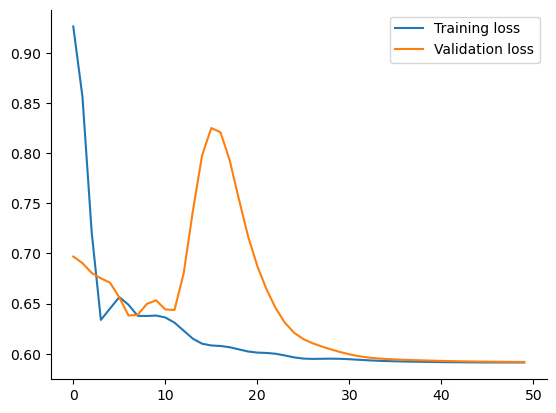

In [199]:
plt.plot(training_data[:, 0], training_data[:, 1], label="Training loss")
plt.plot(training_data[:, 0], training_data[:, 2], label="Validation loss")
plt.legend()

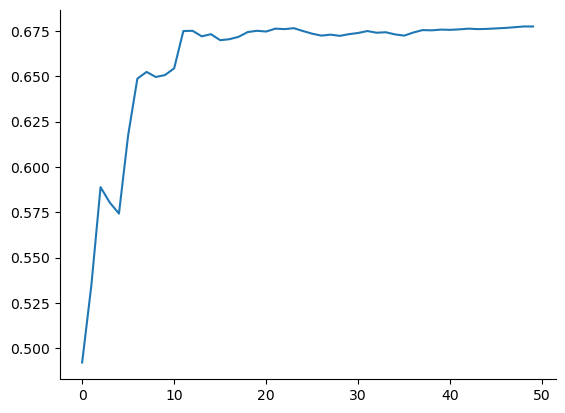

In [200]:
plt.plot(training_data[:, 0], training_data[:, -1])